Pie chart saved as 'budget_allocation_pie_chart.png'


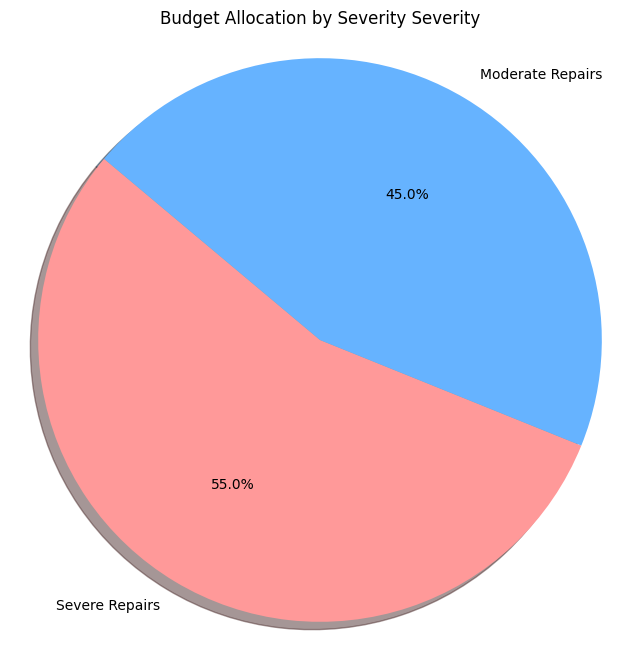

In [1]:
import matplotlib.pyplot as plt

# Data from your Table 5.2 (Simulated Results)
# Adjust these values if your simulation produced different numbers
labels = ['Severe Repairs', 'Moderate Repairs', 'Minor Repairs (Unfunded)']
# Example: 150k + 120k = 270k (Severe), 80k + 90k + 50k = 220k (Moderate), 0 (Minor)
# Let's use percentages or raw amounts. Here using raw amounts for the funded parts.
# Severe: 270,000
# Moderate: 220,000
# Remaining/Unfunded: (Representing the gap or just showing funded distribution)

# Let's stick to the Funded distribution for clarity as per your description
# "Severe repairs accounted for approximately 55%... Moderate utilized remaining 45%"
sizes = [55, 45] 
labels_funded = ['Severe Repairs', 'Moderate Repairs']
colors = ['#ff9999', '#66b3ff'] # Red-ish for Severe, Blue-ish for Moderate

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_funded, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Budget Allocation by Severity Severity')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the chart
plt.savefig('budget_allocation_pie_chart.png')
print("Pie chart saved as 'budget_allocation_pie_chart.png'")
plt.show()

Pie chart saved as 'budget_allocation_pie_chart.png'


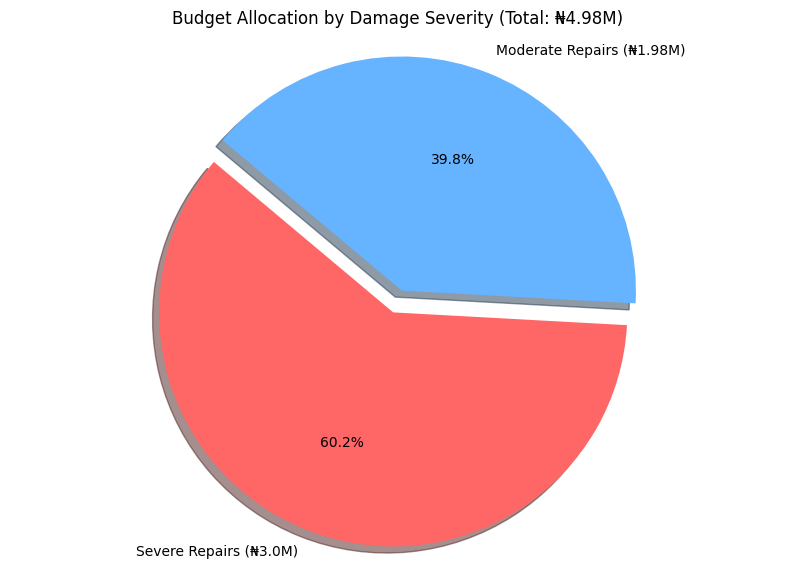

In [2]:
import matplotlib.pyplot as plt

# Data derived from Table 5.2
# Total Spent: 4,980,000
severe_cost = 850000 + 1200000 + 950000  # 3,000,000
moderate_cost = 450000 + 600000 + 550000 + 380000 # 1,980,000

# Data for the chart
labels = ['Severe Repairs (₦3.0M)', 'Moderate Repairs (₦1.98M)']
sizes = [severe_cost, moderate_cost]
colors = ['#ff6666', '#66b3ff'] # Red for Severe, Blue for Moderate
explode = (0.1, 0)  # explode the 1st slice (Severe) slightly

# Create the pie chart
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Budget Allocation by Damage Severity (Total: ₦4.98M)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the figure
plt.savefig('budget_allocation_pie_chart.png')
print("Pie chart saved as 'budget_allocation_pie_chart.png'")
plt.show()

--- Starting Evaluation ---
Model downloaded to: C:\Users\tdngo\.cache\huggingface\hub\models--tomunizua--yolov8-41.7\snapshots\145352059244828ac81490bda39dd4f22e922bf2\best.pt
Model loaded successfully.
Created config: temp_test_dataset.yaml pointing to C:/Users/tdngo/road-infra-ng/api/test

--- Running Validation ---
Ultralytics 8.3.221  Python-3.10.0 torch-2.9.0+cpu CPU (Intel Core i7-8705G 3.10GHz)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 209.487.2 MB/s, size: 64.9 KB)
val: Scanning C:\Users\tdngo\road-infra-ng\api\test\labels.cache... 5758 images, 1790 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5758/5758  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 360/360 0.3it/s 20:59<5.1s
                   all       5758       9675       0.47      0.396      0.367      0.157
    longitudinal crack       2080       3925      0.545      0.26

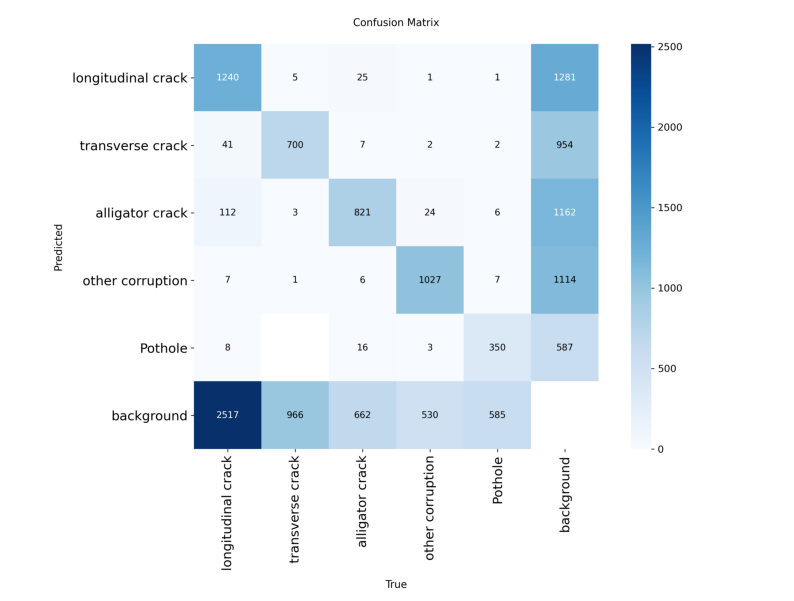

Removed temporary config: temp_test_dataset.yaml


In [17]:
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from huggingface_hub import hf_hub_download
import shutil

def evaluate_yolov8_model(
    hf_repo_id="tomunizua/yolov8-41.7", 
    hf_filename="best.pt", 
test_data_path=r"C:\Users\tdngo\road-infra-ng\api\test"  # <--- Use 'r' for raw string to handle backslashes
):
    print(f"--- Starting Evaluation ---")
    
    # 1. Verify Path Exists
    if not os.path.exists(test_data_path):
        print(f"Error: Test data path not found at: {test_data_path}")
        return

    # 2. Download Model
    print(f"Downloading model '{hf_filename}' from '{hf_repo_id}'...")
    try:
        model_path = hf_hub_download(repo_id=hf_repo_id, filename=hf_filename)
        print(f"Model downloaded to: {model_path}")
    except Exception as e:
        print(f"Error downloading model: {e}")
        return

    # 3. Load Model
    try:
        model = YOLO(model_path)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading YOLO model: {e}")
        return

    # 4. Prepare Dataset YAML
    # IMPORTANT: Convert Windows backslashes to forward slashes for YAML compatibility
    abs_path = os.path.abspath(test_data_path).replace("\\", "/")
    
    yaml_content = f"""
    path: {abs_path}
    train: images 
    val: images 
    test: images 
    
    names:
      0: longitudinal crack
      1: transverse crack
      2: alligator crack
      3: other corruption
      4: Pothole
    """
    
    yaml_path = "temp_test_dataset.yaml"
    with open(yaml_path, "w") as f:
        f.write(yaml_content)
    print(f"Created config: {yaml_path} pointing to {abs_path}")

    # 5. Run Validation
    print("\n--- Running Validation ---")
    try:
        # Setting split='val' because we mapped 'val' to our test images in the YAML
        results = model.val(data=yaml_path, split='val', plots=True, save=True)
    except Exception as e:
        print(f"Error during validation: {e}")
        # Clean up before exiting
        if os.path.exists(yaml_path): os.remove(yaml_path)
        return

    # 6. Metrics & Visualization
    print("\n--- Performance Metrics ---")
    print(f"mAP@50:    {results.box.map50:.4f}")
    print(f"mAP@50-95: {results.box.map:.4f}")
    print(f"Precision: {results.box.mp:.4f}")
    print(f"Recall:    {results.box.mr:.4f}")
    
    save_dir = results.save_dir
    print(f"\nResults saved to: {save_dir}")
    
    # Attempt to show confusion matrix
    cm_path = os.path.join(save_dir, "confusion_matrix.png")
    if os.path.exists(cm_path):
        print("Displaying Confusion Matrix...")
        try:
            img = plt.imread(cm_path)
            plt.figure(figsize=(10, 8))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except:
            print(f"Could not display plot. check {cm_path}")
    
    # Cleanup
    if os.path.exists(yaml_path):
        os.remove(yaml_path)
        print(f"Removed temporary config: {yaml_path}")

if __name__ == "__main__":
    # UPDATE THIS to exactly where your 'images' and 'labels' folders are.
    # Use 'r' before the string or double backslashes '\\'
    TEST_FOLDER_PATH = r"C:\Users\tdngo\road-infra-ng\api\test" 
    
    evaluate_yolov8_model(test_data_path=TEST_FOLDER_PATH)